### Notebook for the label transfer of HLCA Epithelial-Stromal to Healthy-CTRL with `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Institute of Computational Biology - Computational Health Department - Helmholtz Munich**
- v221124

### Import required modules

In [1]:
import torch
import scvi
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

Global seed set to 0
/home/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.3.0
absl                NA
asttokens           NA
attr                22.1.0
backcall            0.2.0
certifi             2022.12.07
charset_normalizer  2.1.1
chex                0.1.5
comm                0.1.2
contextlib2         NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.4
decorator           5.1.1
docrep              0.3.2
entrypoints         0.4
etils               0.9.0
executing           1.2.0
flax                0.6.3
fsspec              2022.11.0
google              NA
h5py                3.7.0
idna                3.4
igraph              0.10.2
ipykernel           6.19.2
ipywidgets          8.0.3
jax                 0.4.6
jaxlib              0.4.6
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.0
lightning_fabric    1.9.0
lightning_utilities 0.6.0.post0
llvmlite            0.39.1
louvain       

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Global seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

### Read in Healthy data

In [5]:
hlca_epistr = sc.read_h5ad('/home/cartalop/data/carlos/single_cell/lung/hlca/LCA_EpiStr_ctl221123.h5ad')
hlca_epistr

AnnData object with n_obs × n_vars = 307282 × 28527
    obs: 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'sample', 'cell_states', 'status', 'domain_label'
    var: 'gene_symbols', 'gene_ids', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection'
    layers: 'counts'

In [6]:
hlca_epistr_raw = anndata.AnnData(X = hlca_epistr.layers['counts'], var = hlca_epistr.var, obs = hlca_epistr.obs)
hlca_epistr_raw.obs['seed_labels'] = hlca_epistr_raw.obs['cell_states'].copy()
hlca_epistr_raw.obs['donor'] = hlca_epistr_raw.obs['sample'].copy()
hlca_epistr_raw

AnnData object with n_obs × n_vars = 307282 × 28527
    obs: 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'sample', 'cell_states', 'status', 'domain_label', 'seed_labels', 'donor'
    var: 'gene_symbols', 'gene_ids', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection'

In [7]:
hlca_epistr_raw.obs['ann_level_4'].value_counts()

None                         73969
Suprabasal                   45758
Multiciliated                40094
Basal resting                38955
Goblet                       38471
Club                         38111
Adventitial fibroblasts      10321
Alveolar fibroblasts          5182
Transitional Club-AT2         3975
Pericytes                     3032
SMG serous                    2889
Peribronchial fibroblasts     1573
SMG duct                      1274
Deuterosomal                  1004
AT2 proliferating              976
Ionocyte                       561
SMG mucous                     537
Subpleural fibroblasts         276
Tuft                           165
Neuroendocrine                 159
Name: ann_level_4, dtype: int64

- Remove cells with 'None' annotation

In [8]:
hlca_epistr_clean = hlca_epistr_raw[~hlca_epistr_raw.obs['ann_level_4'].isin(['None'])]

sc.pp.filter_genes(hlca_epistr_clean, min_cells = 3)

hlca_epistr_clean.obs['ann_level_4'].value_counts()

filtered out 374 genes that are detected in less than 3 cells


Suprabasal                   45758
Multiciliated                40094
Basal resting                38955
Goblet                       38471
Club                         38111
Adventitial fibroblasts      10321
Alveolar fibroblasts          5182
Transitional Club-AT2         3975
Pericytes                     3032
SMG serous                    2889
Peribronchial fibroblasts     1573
SMG duct                      1274
Deuterosomal                  1004
AT2 proliferating              976
Ionocyte                       561
SMG mucous                     537
Subpleural fibroblasts         276
Tuft                           165
Neuroendocrine                 159
Name: ann_level_4, dtype: int64

In [9]:
hlca_epistr_clean.obs['cell_states'] = hlca_epistr_clean.obs['ann_level_4'].copy()
hlca_epistr_clean.obs['cell_states'].cat.categories

Index(['AT2 proliferating', 'Adventitial fibroblasts', 'Alveolar fibroblasts',
       'Basal resting', 'Club', 'Deuterosomal', 'Goblet', 'Ionocyte',
       'Multiciliated', 'Neuroendocrine', 'Peribronchial fibroblasts',
       'Pericytes', 'SMG duct', 'SMG mucous', 'SMG serous',
       'Subpleural fibroblasts', 'Suprabasal', 'Transitional Club-AT2',
       'Tuft'],
      dtype='object')

In [10]:
hlca_epistr_clean.obs['seed_labels'] = hlca_epistr_clean.obs['cell_states'].copy()
hlca_epistr_clean

AnnData object with n_obs × n_vars = 233313 × 28153
    obs: 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'sample', 'cell_states', 'status', 'domain_label', 'seed_labels', 'donor'
    var: 'gene_symbols', 'gene_ids', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells'

### Read in other unannotated datasets

In [11]:
query = sc.read_h5ad('../data/Marburg_All_QCed_pre-processed_light_ctl230314.h5ad')
query

AnnData object with n_obs × n_vars = 115102 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_by_counts-V5', 'total_counts-V5', 'n_cells_by_counts-V6', 'mean_cou

In [12]:
query_healthy = query[query.obs['disease'].isin(['healthy'])]
query_healthy

View of AnnData object with n_obs × n_vars = 55336 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_by_counts-V5', 'total_counts-V5', 'n_cells_by_counts-V6', 'm

In [13]:
healthy_ctrl = query_healthy[query_healthy.obs['infection'].isin(['CTRL'])]
healthy_ctrl.obs['seed_labels'] = 'Unknown'
healthy_ctrl

AnnData object with n_obs × n_vars = 28175 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'seed_labels'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_by_counts-V5', 'total_counts-V5', 'n_cells_by_counts-

In [14]:
adata = hlca_epistr_clean.concatenate(healthy_ctrl, batch_key = 'group', batch_categories = ['hlca_epistr', 'healthy_ctrl'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 261488 × 18774
    obs: 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'sample', 'cell_states', 'status', 'domain_label', 'seed_labels', 'donor', 'sex', 'age', 'ethnicity', 'PaCO2', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group'
    var: 'highly_variable-healthy_ctrl', 'highly_variable_nbatches-healthy_ctrl', 'mt-healthy_ctrl', 'ribo-healthy_ctrl', 'n_cells_by_counts-V1-healthy_ctrl', 'mean_counts-V1-healthy_ctrl', 'pct_dropout_by_counts-V1-healthy_ctrl', 'total_counts-V1-healthy_ctrl', 'n_cells_by_counts-V2-healthy_ctrl', 'mean_counts-V2-healthy_ctrl', 'pct_dropout_by_coun

### Select HVGs

In [15]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category') 

In [16]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

### Transfer of annotation with scANVI

In [17]:
scvi.model.SCVI.setup_anndata(adata, batch_key = 'donor', labels_key = "seed_labels", layer = 'counts')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [18]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

In [19]:
scvi_model.train(100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [24:34<00:00, 14.55s/it, loss=7.17e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [24:34<00:00, 14.75s/it, loss=7.17e+03, v_num=1]


### Label transfer with `scANVI` 

In [20]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [21]:
scanvi_model.train(25)


INFO     Training for 25 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25/25: 100%|██████████| 25/25 [14:32<00:00, 34.87s/it, loss=7.31e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|██████████| 25/25 [14:32<00:00, 34.91s/it, loss=7.31e+03, v_num=1]


In [22]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [23]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:52)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:58)


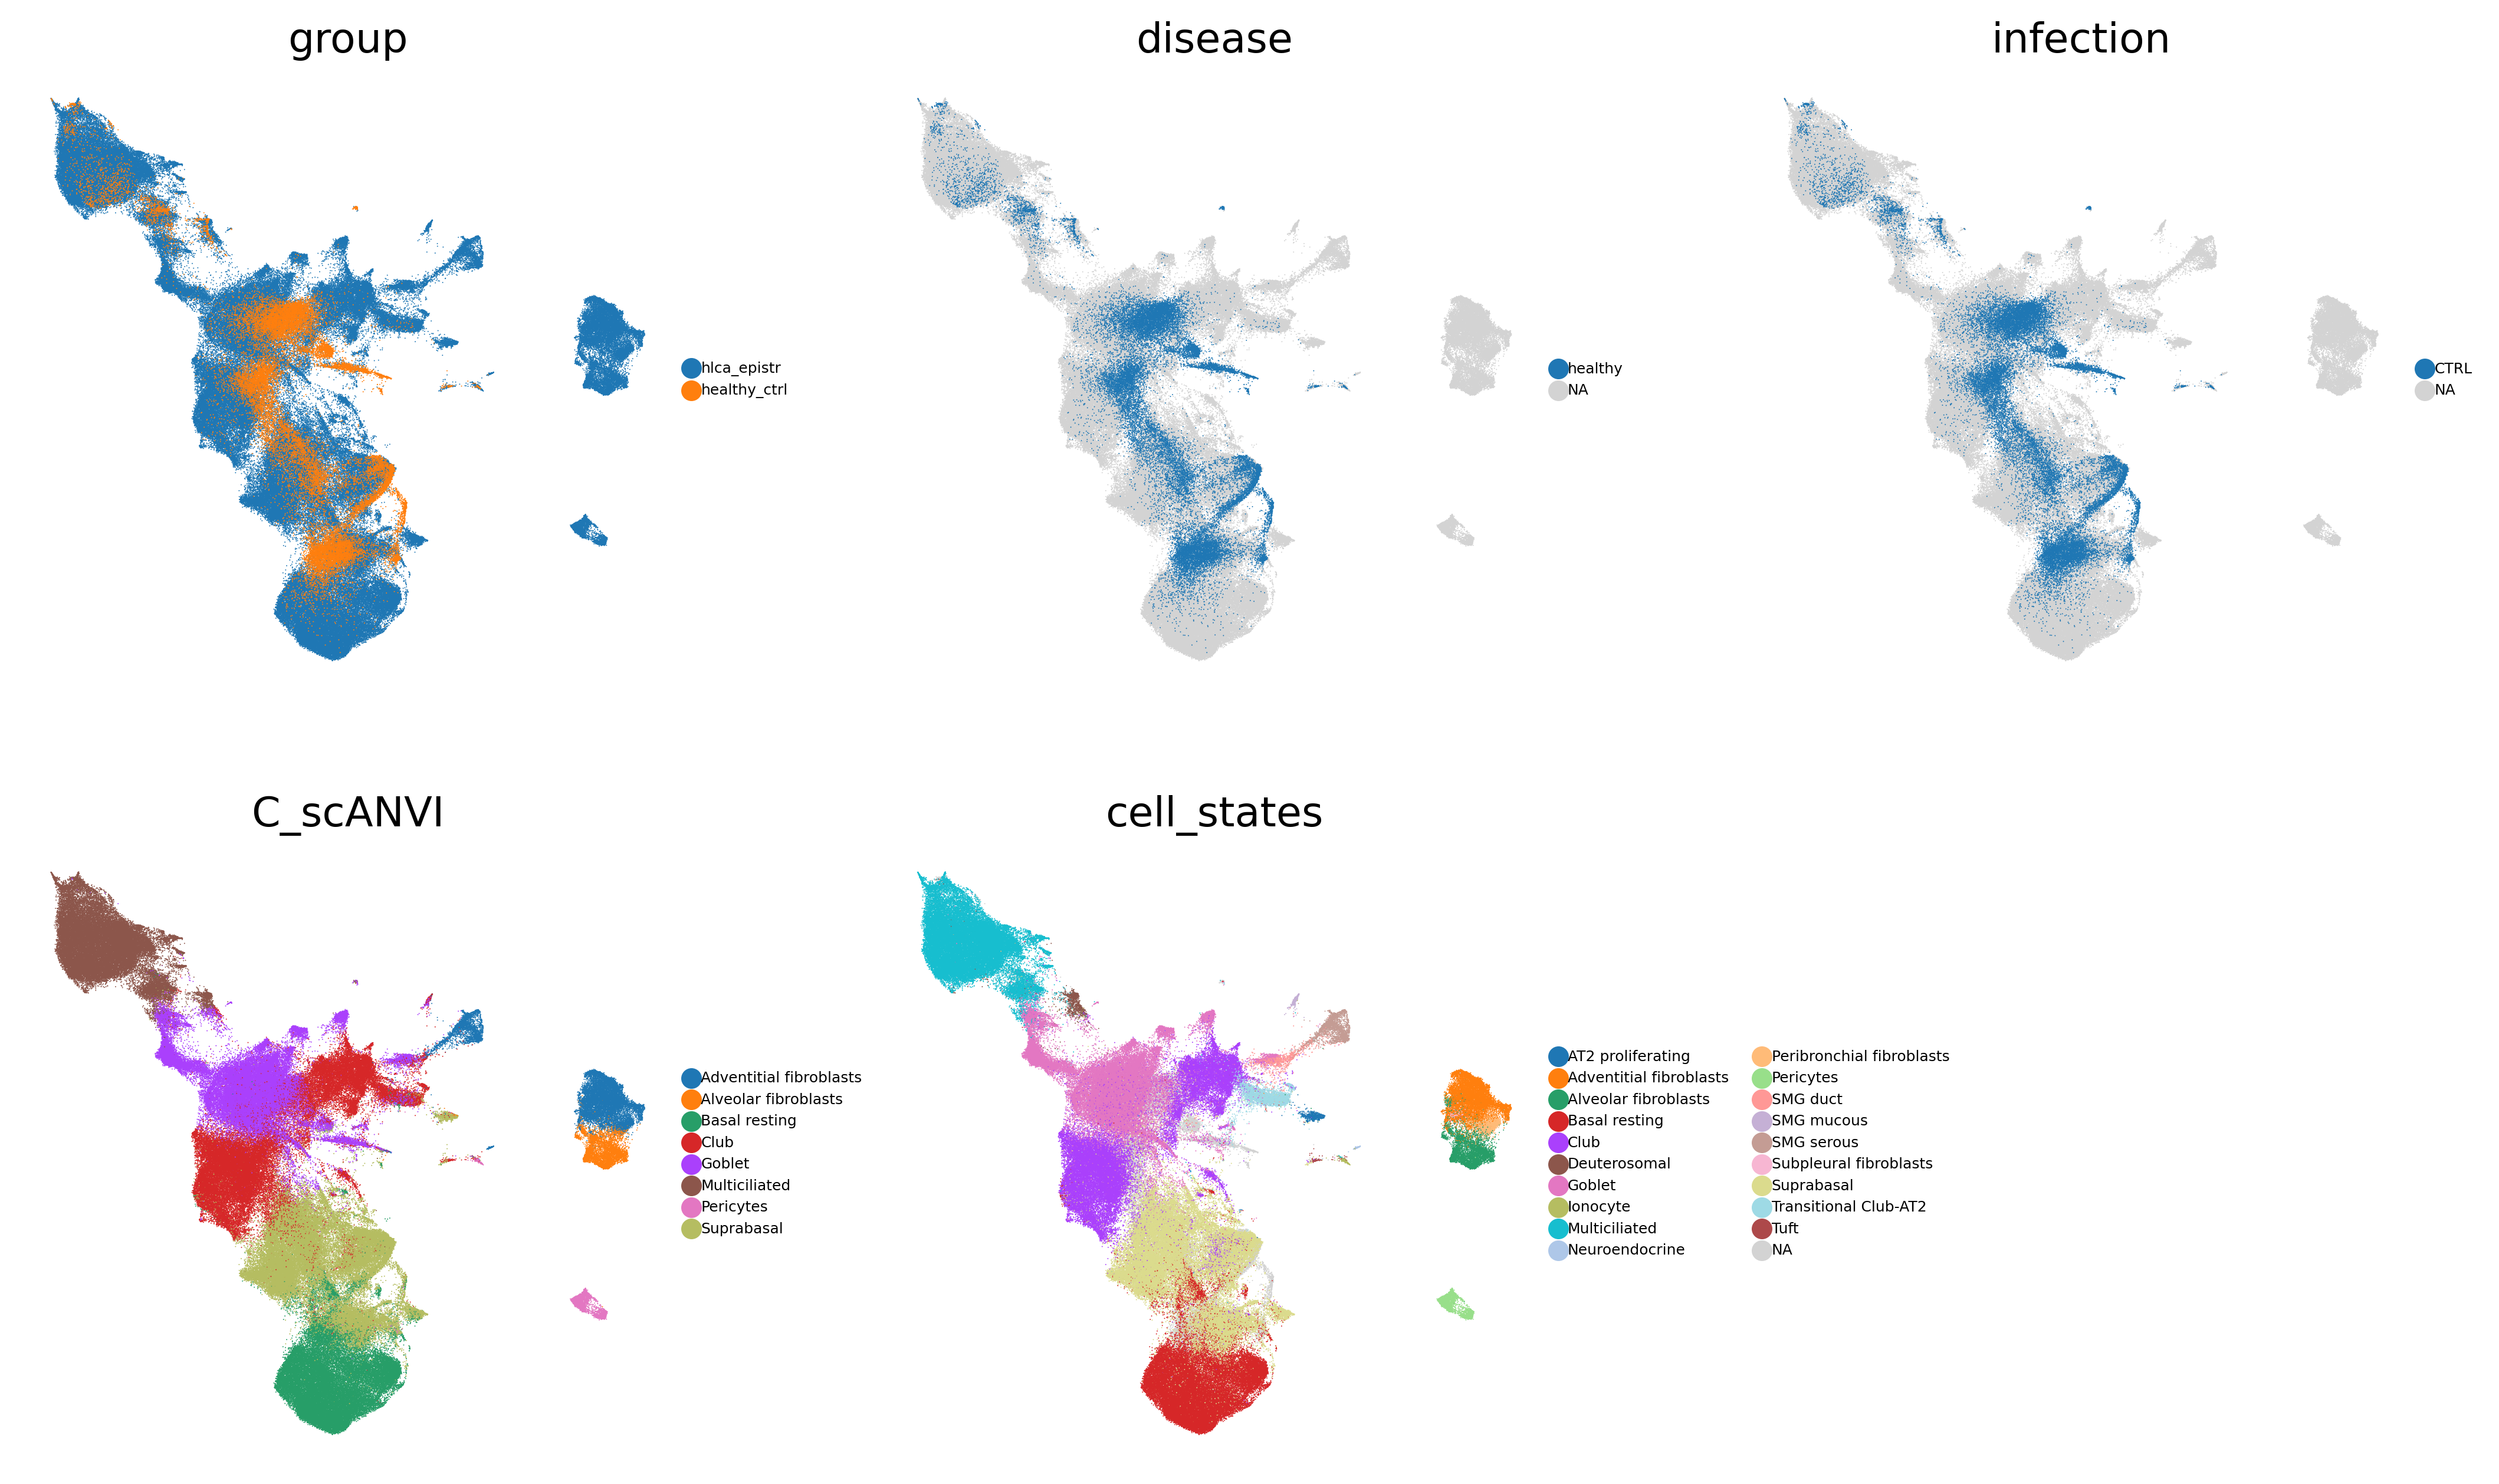

In [24]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 2, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['group', 'disease', 'infection', 'C_scANVI', 'cell_states'], size = 0.6, legend_fontsize = 5, ncols = 3)

### Export annotated sample object 

In [25]:
query_annotated = adata[adata.obs['group'].isin(['healthy_ctrl'])]
query_annotated.obs_names

Index(['80307-ST07_CSE_CTRL-V1-healthy_ctrl',
       '339288-ST07_CSE_CTRL-V1-healthy_ctrl',
       '460986-ST07_CSE_CTRL-V1-healthy_ctrl',
       '401039-ST07_CSE_CTRL-V1-healthy_ctrl',
       '312661-ST07_CSE_CTRL-V1-healthy_ctrl',
       '231516-ST07_CSE_CTRL-V1-healthy_ctrl',
       '615199-ST07_CSE_CTRL-V1-healthy_ctrl',
       '364087-ST07_CSE_CTRL-V1-healthy_ctrl',
       '431090-ST07_CSE_CTRL-V1-healthy_ctrl',
       '347885-ST07_CSE_CTRL-V1-healthy_ctrl',
       ...
       '1647838-GER02_CTRL-V6-healthy_ctrl',
       '10059318-GER02_CTRL-V6-healthy_ctrl',
       '3113495-GER02_CTRL-V6-healthy_ctrl',
       '7983748-GER02_CTRL-V6-healthy_ctrl',
       '10326936-GER02_CTRL-V6-healthy_ctrl',
       '1643539-GER02_CTRL-V6-healthy_ctrl',
       '1044875-GER02_CTRL-V6-healthy_ctrl',
       '9882253-GER02_CTRL-V6-healthy_ctrl',
       '1638166-GER02_CTRL-V6-healthy_ctrl',
       '3419607-GER02_CTRL-V6-healthy_ctrl'],
      dtype='object', length=28175)

In [26]:
query_annotated.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in query_annotated.obs.index])
query_annotated.obs.index

Index(['80307-ST07_CSE_CTRL-V1', '339288-ST07_CSE_CTRL-V1',
       '460986-ST07_CSE_CTRL-V1', '401039-ST07_CSE_CTRL-V1',
       '312661-ST07_CSE_CTRL-V1', '231516-ST07_CSE_CTRL-V1',
       '615199-ST07_CSE_CTRL-V1', '364087-ST07_CSE_CTRL-V1',
       '431090-ST07_CSE_CTRL-V1', '347885-ST07_CSE_CTRL-V1',
       ...
       '1647838-GER02_CTRL-V6', '10059318-GER02_CTRL-V6',
       '3113495-GER02_CTRL-V6', '7983748-GER02_CTRL-V6',
       '10326936-GER02_CTRL-V6', '1643539-GER02_CTRL-V6',
       '1044875-GER02_CTRL-V6', '9882253-GER02_CTRL-V6',
       '1638166-GER02_CTRL-V6', '3419607-GER02_CTRL-V6'],
      dtype='object', length=28175)

In [27]:
healthy_ctrl.obs['C_scANVI'] = query_annotated.obs['C_scANVI'].copy()
healthy_ctrl.obs_names

Index(['80307-ST07_CSE_CTRL-V1', '339288-ST07_CSE_CTRL-V1',
       '460986-ST07_CSE_CTRL-V1', '401039-ST07_CSE_CTRL-V1',
       '312661-ST07_CSE_CTRL-V1', '231516-ST07_CSE_CTRL-V1',
       '615199-ST07_CSE_CTRL-V1', '364087-ST07_CSE_CTRL-V1',
       '431090-ST07_CSE_CTRL-V1', '347885-ST07_CSE_CTRL-V1',
       ...
       '1647838-GER02_CTRL-V6', '10059318-GER02_CTRL-V6',
       '3113495-GER02_CTRL-V6', '7983748-GER02_CTRL-V6',
       '10326936-GER02_CTRL-V6', '1643539-GER02_CTRL-V6',
       '1044875-GER02_CTRL-V6', '9882253-GER02_CTRL-V6',
       '1638166-GER02_CTRL-V6', '3419607-GER02_CTRL-V6'],
      dtype='object', name='Cell_Index', length=28175)

In [28]:
healthy_ctrl.obs['C_scANVI'].cat.categories

Index(['Adventitial fibroblasts', 'Alveolar fibroblasts', 'Basal resting',
       'Club', 'Goblet', 'Multiciliated', 'Pericytes', 'Suprabasal'],
      dtype='object')

In [29]:
healthy_ctrl.obs['C_scANVI'].value_counts()

Suprabasal                 8680
Goblet                     7407
Club                       6560
Basal resting              3351
Multiciliated              2031
Pericytes                    83
Adventitial fibroblasts      60
Alveolar fibroblasts          3
Name: C_scANVI, dtype: int64

In [30]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis = 0).astype(int), adata.X.sum(axis = 0))


In [31]:
X_is_raw(healthy_ctrl)

True

In [32]:
healthy_ctrl.obs['C_scANVI'].value_counts()

Suprabasal                 8680
Goblet                     7407
Club                       6560
Basal resting              3351
Multiciliated              2031
Pericytes                    83
Adventitial fibroblasts      60
Alveolar fibroblasts          3
Name: C_scANVI, dtype: int64

### Export annotated Helathy-CTRL object with raw counts

In [34]:
healthy_ctrl.write('/home/cartalop/data/carlos/single_cell/COPD_IAV/grch38-iav/scanvi_annotated/Marburg_Healthy_CTRL_ctl230315_scANVI_annot.raw.h5ad')